# Bài tập lớn: Chấm điểm tín dụng với phương pháp ensemble learning

Mục tiêu: Cài đặt mô hình đánh giá tín dụng Lasso Logistic Regression Ensemble cho tập dữ liệu Kaggle, so sánh với các phương pháp học máy cơ bản như cây quyết định, rừng ngẫu nhiên và hồi quy logistic.


In [1]:
from google.colab import drive
drive.mount("/content/drive", force_remount = True)
import os
os.chdir("drive/My Drive/Colab Notebooks/Study/BML_Project/Project")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls "drive/My Drive/Colab Notebooks/Study/BML_Project/Project"

## Phần 1: Thử nghiệm các phương pháp học máy trên cho tập dữ liệu Kaggle 
Tập dữ liệu này đã được tiền xử lý một cách tốt nhất (theo bài báo Wang et al, 2016), các phương pháp tiền xử lý đã được giới thiệu trong bài giảng

In [0]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectFromModel, SelectKBest
from sklearn.pipeline import make_pipeline
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier

sns.set(style='white', context='notebook', palette='deep')
pd.options.display.max_columns = 100
from transform_data import transform_data

In [3]:
import pandas as pd
import numpy as np

kaggle_data = pd.read_csv("./data/cs-training.csv")
kaggle_data.drop(['Unnamed: 0'], axis=1, inplace=True)
process_data = transform_data(kaggle_data)
process_data.head()

,SeriousDlqin2yrs,UnknownNumberOfDependents,UnknownMonthlyIncome,NoDependents,NoIncome,ZeroDebtRatio,UnknownIncomeDebtRatio,WeirdRevolvingUtilization,ZeroRevolvingUtilization,Log.Debt,RevolvingLines,HasRevolvingLines,HasRealEstateLoans,HasMultipleRealEstateLoans,EligibleSS,DTIOver33,DTIOver43,DisposableIncome,RevolvingToRealEstate,NumberOfTime30-59DaysPastDueNotWorseLarge,NumberOfTime30-59DaysPastDueNotWorse96,NumberOfTime30-59DaysPastDueNotWorse98,Never30-59DaysPastDueNotWorse,NumberOfTime60-89DaysPastDueNotWorseLarge,NumberOfTime60-89DaysPastDueNotWorse96,NumberOfTime60-89DaysPastDueNotWorse98,Never60-89DaysPastDueNotWorse,NumberOfTimes90DaysLateLarge,NumberOfTimes90DaysLate96,NumberOfTimes90DaysLate98,Never90DaysLate,IncomeDivBy10,IncomeDivBy100,IncomeDivBy1000,IncomeDivBy5000,Weird0999Utilization,FullUtilization,ExcessUtilization,NumberOfTime30-89DaysPastDueNotWorse,Never30-89DaysPastDueNotWorse,NeverPastDue,Log.RevolvingUtilizationTimesLines,Log.RevolvingUtilizationOfUnsecuredLines,DelinquenciesPerLine,MajorDelinquenciesPerLine,MinorDelinquenciesPerLine,DelinquenciesPerRevolvingLine,MajorDelinquenciesPerRevolvingLine,MinorDelinquenciesPerRevolvingLine,Log.DebtPerLine,Log.DebtPerRealEstateLine,Log.DebtPerPerson,RevolvingLinesPerPerson,RealEstateLoansPerPerson,YearsOfAgePerDependent,Log.MonthlyIncome,Log.IncomePerPerson,Log.IncomeAge,Log.NumberOfTimesPastDue,Log.NumberOfTimes90DaysLate,Log.NumberOfTime30-59DaysPastDueNotWorse,Log.NumberOfTime60-89DaysPastDueNotWorse,Log.Ratio90to30-59DaysLate,Log.Ratio90to60-89DaysLate,AnyOpenCreditLinesOrLoans,Log.NumberOfOpenCreditLinesAndLoans,Log.NumberOfOpenCreditLinesAndLoansPerPerson,Has.Dependents,Log.HouseholdSize,Log.DebtRatio,Log.DebtPerDelinquency,Log.DebtPer90DaysLate,Log.UnknownIncomeDebtRatio,Log.UnknownIncomeDebtRatioPerPerson,Log.UnknownIncomeDebtRatioPerLine,Log.UnknownIncomeDebtRatioPerRealEstateLine,Log.UnknownIncomeDebtRatioPerDelinquency,Log.UnknownIncomeDebtRatioPer90DaysLate,Log.NumberRealEstateLoansOrLines,LowAge,Log.age
0,1,0,0,0,0,0,0,0.0,0,8.898802,7,1,1,1,0,1,1,1796.802984,1.0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,2,0,0,1.850482,-0.266408,0.153846,0.0,0.153846,0.285714,0.0,0.285714,6.259745,6.952892,7.800190,2.333333,2.0,15.0,9.118225,8.019613,5.289584,0.693147,0.0,0.693147,0.0,-0.693147,0.0,1,2.564949,1.466337,1,1.098612,-0.219423,7.800190,8.898802,0.0,-1.098612,-2.639057,-1.945910,-1.098612,0.000000,1.791759,0,3.332205
1,0,0,0,0,0,0,0,0.0,0,5.758517,4,1,0,0,0,0,0,2283.121877,4.0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,1.574557,-0.043794,0.000000,0.0,0.000000,0.000000,0.0,0.000000,4.149079,5.758517,5.065370,2.000000,0.0,20.0,7.863267,7.170120,4.149695,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.386294,0.693147,1,0.693147,-2.104749,5.758517,5.758517,0.0,-0.693147,-1.609438,0.000000,0.000000,0.000000,0.000000,0,3.135494
2,0,0,0,1,0,0,0,0.0,0,5.556499,2,1,0,0,0,0,0,2783.085113,2.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.839997,-0.418277,1.000000,0.5,0.500000,1.000000,0.5,0.500000,4.457887,5.556499,5.556499,2.000000,0.0,38.0,8.020270,8.020270,4.356709,0.693147,0.0,0.000000,0.0,0.000000,0.0,1,0.693147,0.693147,0,0.000000,-2.463771,4.457887,4.863352,0.0,0.000000,-1.098612,0.000000,-1.098612,-0.693147,0.000000,0,3.044522
3,0,0,0,1,0,0,0,0.0,0,4.778821,5,1,0,0,0,0,0,3181.036049,5.0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,1,1,0.774289,-1.453247,0.000000,0.0,0.000000,0.000000,0.0,0.000000,2.987061,4.778821,4.778821,5.000000,0.0,30.0,8.101678,8.101678,4.667691,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.609438,1.609438,0,0.000000,-3.322857,4.778821,4.778821,0.0,0.000000,-1.791759,0.000000,0.000000,0.000000,0.000000,0,2.564949
4,0,0,0,1,0,0,0,0.0,0,7.368324,6,1,1,0,0,0,0,62003.024906,3.0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1.863062,-0.097349,0.142857,0.0,0.142857,0.166667,0.0,0.166667,5.288882,6.675177,7.368324,6.000000,1.0,49.0,11.060180,11.060180,7.148157,0.000000,0.0,0.000000,0.0,0.000000,0.0,1,1.945910,1.945910,0,0.000000,-3.691856,6.675177,7.368324,0.0

In [0]:
14000**0.5

In [0]:
import time
#visualization of the dataset
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [5]:
pca = PCA(n_components=6)
pca_result = pca.fit_transform(kaggle_data.loc[:, kaggle_data.columns != 'SeriousDlqin2yrs'])
df_subset = pd.DataFrame()
df_subset['pca-one'] = pca_result[:,0]
df_subset['pca-two'] = pca_result[:,1] 
df_subset['pca-three'] = pca_result[:,2]
df_subset['pca-four'] = pca_result[:,3]
df_subset['pca-five'] = pca_result[:,4]
df_subset['pca-six'] = pca_result[:,5]
df_subset["y"] = process_data.SeriousDlqin2yrs
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [9.66866286e-01 2.12569117e-02 1.12867801e-02 4.11507003e-04
 1.77674762e-04 6.27524805e-07]


In [0]:
df_good_debt  = df_subset.loc[df_subset.y == 0]

In [0]:
df_good_debt.head()

In [0]:
df_good_debt.loc[:, df_good_debt.columns != 'y']

In [8]:
k_list = []
inert_list = []
from sklearn.cluster import KMeans
for k in range (1, 21):
 
	# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
  kmeans_model = KMeans(n_clusters=k, random_state=1).fit(df_good_debt.loc[:, df_good_debt.columns != 'y'])
	
	# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
	# labels = kmeans_model.labels_
 
	# Sum of distances of samples to their closest cluster center
  inertia = kmeans_model.inertia_
  k_list.append(k)
  inert_list.append(inertia)
  print("k:",k, " cost:", inertia)

k: 1  cost: 51623325360218.64
k: 2  cost: 24191353243621.688
k: 3  cost: 15010787335478.123
k: 4  cost: 11445273821918.578
k: 5  cost: 8591682046752.583
k: 6  cost: 6225166714082.839
k: 7  cost: 5156798146532.405
k: 8  cost: 4264495004021.6924
k: 9  cost: 3474771555426.13
k: 10  cost: 2902361653150.739
k: 11  cost: 2564332018118.977
k: 12  cost: 2201786303124.612
k: 13  cost: 1918607223551.8984
k: 14  cost: 1715837927395.3796
k: 15  cost: 1537905832995.7686
k: 16  cost: 1336475626080.0037
k: 17  cost: 1192338294284.2288
k: 18  cost: 1096745190470.6549
k: 19  cost: 1024514592020.1628
k: 20  cost: 954594815238.3191


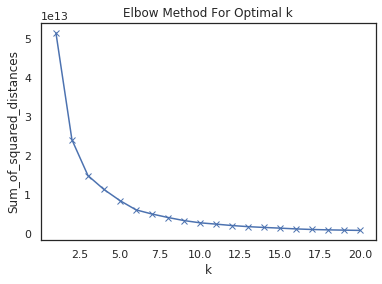

In [9]:
import matplotlib.pyplot as plt
plt.plot(k_list, inert_list, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
#Optimal k nếu chuyển dữ liệu về PCA 6 dimension: 5,6

In [0]:
k_list_2 = []
inert_list_2 = []
from sklearn.cluster import KMeans
for k in range (1, 119):
 
	# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
  kmeans_model = KMeans(n_clusters=k, random_state=1).fit(kaggle_data.loc[:, kaggle_data.columns != 'SeriousDlqin2yrs'])
	
	# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
	# labels = kmeans_model.labels_
 
	# Sum of distances of samples to their closest cluster center
  inertia = kmeans_model.inertia_
  k_list_2.append(k)
  inert_list_2.append(inertia)
  print("k:",k, " cost:", inertia)

In [0]:
import matplotlib.pyplot as plt
plt.plot(k_list_2, inert_list_2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [0]:
k_list = []
inert_list = []
from sklearn.cluster import KMeans
for k in range (1, 119):
 
	# Create a kmeans model on our data, using k clusters.  random_state helps ensure that the algorithm returns the same results each time.
  kmeans_model = KMeans(n_clusters=k, random_state=1).fit(df_good_debt.loc[:, df_good_debt.columns != 'y'])
	
	# These are our fitted labels for clusters -- the first cluster has label 0, and the second has label 1.
	# labels = kmeans_model.labels_
 
	# Sum of distances of samples to their closest cluster center
  inertia = kmeans_model.inertia_
  k_list.append(k)
  inert_list.append(inertia)
  print("k:",k, " cost:", inertia)

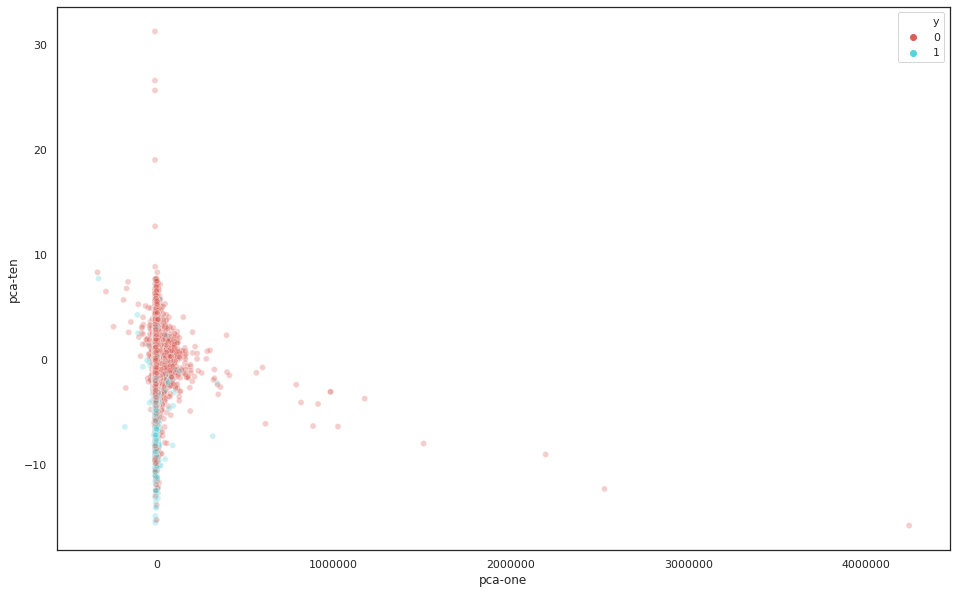

In [0]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="pca-one", y="pca-ten",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_subset,
    legend="full",
    alpha=0.3
)

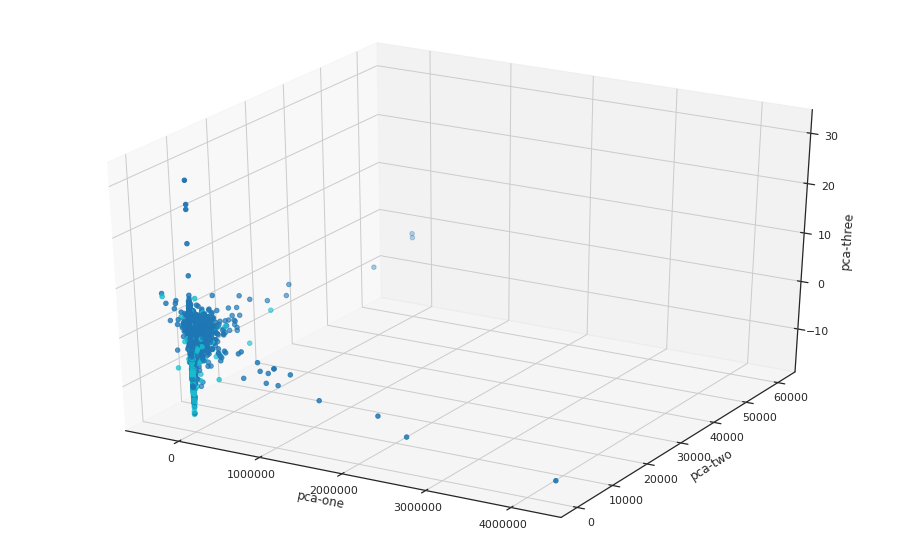

In [0]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_subset["pca-one"], 
    ys=df_subset["pca-four"], 
    zs=df_subset["pca-ten"], 
    c=df_subset["y"], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

In [0]:
import time
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(process_data)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 150000 samples in 8.464s...
[t-SNE] Computed neighbors for 150000 samples in 48.530s...
[t-SNE] Computed conditional probabilities for sample 1000 / 150000
[t-SNE] Computed conditional probabilities for sample 2000 / 150000
[t-SNE] Computed conditional probabilities for sample 3000 / 150000
[t-SNE] Computed conditional probabilities for sample 4000 / 150000
[t-SNE] Computed conditional probabilities for sample 5000 / 150000
[t-SNE] Computed conditional probabilities for sample 6000 / 150000
[t-SNE] Computed conditional probabilities for sample 7000 / 150000
[t-SNE] Computed conditional probabilities for sample 8000 / 150000
[t-SNE] Computed conditional probabilities for sample 9000 / 150000
[t-SNE] Computed conditional probabilities for sample 10000 / 150000
[t-SNE] Computed conditional probabilities for sample 11000 / 150000
[t-SNE] Computed conditional probabilities for sample 12000 / 150000
[t-SNE] Computed conditional proba

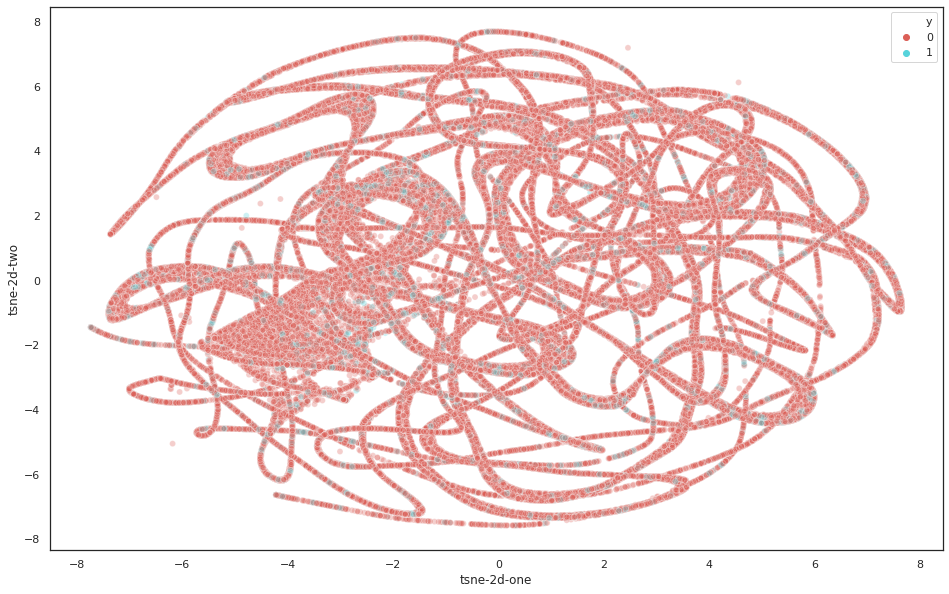

In [0]:
df_tsne = pd.DataFrame()
df_tsne['tsne-2d-one'] = tsne_results[:,0]
df_tsne['tsne-2d-two'] = tsne_results[:,1]
df_tsne["y"] = process_data.SeriousDlqin2yrs
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="y",
    palette=sns.color_palette("hls", 2),
    data=df_tsne,
    legend="full",
    alpha=0.3
)

In [0]:
#Use parallel coordinates
from pandas.plotting import parallel_coordinates

In [0]:
parallel_coordinates(process_data, class_column = "SeriousDlqin2yrs")

In [0]:
parallel_coordinates(df_subset, class_column = "y")

In [0]:
#Số thuộc tính trên mỗi bản ghi
len(process_data.columns)

81

In [0]:
#Cái này là nhãn
kaggle_data.SeriousDlqin2yrs.value_counts()

0    139974
1     10026
Name: SeriousDlqin2yrs, dtype: int64

### Câu hỏi 1.1: Áp dụng thuật toán cây ra quyết định và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán cây quyết định, đánh giá 
hiệu năng (tính auc) của thuật toán, tính độ quan trọng của các thuộc tính

In [0]:
#### YOUR CODE HERE ####
# Chia dữ liệu
from sklearn.model_selection import train_test_split
x = process_data.loc[:, process_data.columns != 'SeriousDlqin2yrs']
y = process_data.SeriousDlqin2yrs
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

#### END YOUR CODE #####

In [0]:
#Tiến hành phân loại
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# Import accuracy_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [0]:
decision_tree = DecisionTreeClassifier(class_weight= None, criterion= 'entropy', max_depth= 10)
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [0]:
param = {'max_depth': [None, 10, 20 , 30, 40, 50], 'criterion': ['gini', "entropy"], 'class_weight': [None, 'balanced']}
gs =GridSearchCV(decision_tree, param_grid=param, cv=5, n_jobs=-1)
gs.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                  

In [0]:
gs.best_params_

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 10}

In [0]:
y_pred = decision_tree.predict(x_test)
mse_dt = MSE(y_test, y_pred)
standard_deviation = np.sqrt(mse_dt)
standard_deviation

0.2580051679068981

In [0]:
f1_score(y_test, y_pred)

0.2693011342846689

In [0]:
y_train_pred = decision_tree.predict(x_train)

In [0]:
from sklearn.metrics import roc_auc_score
train_auc = roc_auc_score(y_train, y_train_pred)
test_auc = roc_auc_score(y_test, y_pred)

In [0]:
print(train_auc)
print(test_auc)

0.626562332232581
0.5853408539733003


###  Áp dụng thuật toán rừng ngẫu nhiên và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán rừng ngẫu nhiên, đánh giá 
hiệu năng (tính auc) của thuật toán, tính độ quan trọng của các thuộc tính

In [0]:
#### YOUR CODE HERE ####
random_forest = RandomForestClassifier()
random_forest.fit(x_train,y_train)

#### END YOUR CODE #####

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
y_rf_pred = random_forest.predict(x_test)
mse_dt = MSE(y_test, y_rf_pred)
standard_deviation = np.sqrt(mse_dt)

In [0]:
standard_deviation

0.25787593916455254

In [0]:
accuracy_score(y_test, y_rf_pred)

0.9335

### Câu hỏi 1.3: Áp dụng thuật toán hồi quy logistic và đánh giá hiệu năng của thuật toán
Phân chia dữ liệu tiền xử lý thành dữ liệu huấn luyện và kiểm ta, áp dụng thuật toán hồi quy logistic, đánh giá 
hiệu năng (tính auc) của thuật toán, hiện thị hệ số của hồi quy logistic

In [0]:
#### YOUR CODE HERE ####
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression()
logistic_regression.fit(x_train,y_train)

y_log_pred = logistic_regression.predict(x_test)
mse_dt = MSE(y_test, y_log_pred)
standard_deviation_log = np.sqrt(mse_dt)
#### END YOUR CODE #####
print(standard_deviation_log)
print("Độ chính xác của logistic regression là {}".format(accuracy_score(y_test, y_log_pred)))
print("Độ đo auc là {}".format(roc_auc_score(y_test, y_log_pred)))

0.2515949125081825
Độ chính xác của logistic regression là 0.9367
Độ đo auc là 0.5711165469074234


### Câu hỏi 1.4 (câu hỏi nâng cao): Áp dụng thuật toán nâng cao khác như hồi quy logistics Lasso hay kết hợp 
### với hồi quy logistic và kỹ thuât baggin và đánh giá hiệu năng của các thuật toán đó

In [0]:
from sklearn.linear_model import LogisticRegression
ogistic_regression = LogisticRegression()
param = {"penalty": ["l2","l1", "none"], "class_weight": [None, "balanced"], "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}
gs =GridSearchCV(logistic_regression, param_grid=param, scoring = "roc_auc" cv=5, n_jobs=-1)
gs.fit(x_train, y_train)
gs.best_params_

In [0]:
#### YOUR CODE HERE ####
lasso_regression = LogisticRegression(penalty='l1', solver='liblinear')
lasso_regression.fit(x_train,y_train)

y_lass_pred = lasso_regression.predict(x_test)
mse_dt = MSE(y_test, y_lass_pred)
standard_deviation_lass = np.sqrt(mse_dt)
print(standard_deviation_lass)
print("Độ chính xác của logistic regression là {}".format(accuracy_score(y_test, y_lass_pred)))
print("Độ đo auc là {}".format(roc_auc_score(y_test, y_lass_pred)))
#### END YOUR CODE #####

0.2498666310921355
Độ chính xác của logistic regression là 0.9375666666666667
Độ đo auc là 0.5977422491280283


In [0]:
from sklearn.ensemble import BaggingClassifier
bagging = BaggingClassifier()
bagging.fit(x_train,y_train)

y_bag_pred = bagging.predict(x_test)
mse_dt = MSE(y_test, y_bag_pred)
standard_deviation_lass = np.sqrt(mse_dt)
print(standard_deviation_lass)
print("Độ chính xác của bagging là {}".format(accuracy_score(y_test, y_bag_pred)))
print("Độ đo auc là {}".format(roc_auc_score(y_test, y_bag_pred)))
#### END YOUR CODE #####

0.2602562839459085
Độ chính xác của bagging là 0.9322666666666667
Độ đo auc là 0.5805484502710004


### Câu hỏi 2: Áp dụng cây ra quyết định (hồi quy và phân loại) cho các tập dữ liệu khác

### 2.1 Tập dữ liệu Breast cancer

In [0]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

In [0]:
cancer = load_breast_cancer()

In [0]:
print('cancer.keys():\n {}'.format(cancer.keys()))

cancer.keys():
 dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [0]:
print('Kích thước dữ liệu:\n {}'.format(cancer.data.shape))

Kích thước dữ liệu:
 (569, 30)


In [0]:
print('Các thuộc tính: \n{}'.format(cancer.feature_names))

Các thuộc tính: 
['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [0]:
print('Các lớp: \n{}'.format(cancer.target_names))

Các lớp: 
['malignant' 'benign']


** Chia dữ liệu **
- Chia dữ liệu thành:
    - Dữ liệu huấn luyện: 80%
    - Dữ liệu kiểm tra: 20%

In [0]:
# Chia dữ liệu
from sklearn.model_selection import train_test_split
x = cancer.data
y = cancer.target
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [0]:
x_train.shape

(455, 30)

In [0]:
x_test.shape

(114, 30)

In [0]:
# Import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
# Import accuracy_score
from sklearn.metrics import accuracy_score

In [0]:
# Cây quyết định
# tree=DecisionTreeClassifier(max_depth=2,random_state=42)
tree = DecisionTreeClassifier(random_state=42)
# tree=DecisionTreeClassifier(max_depth=4,random_state=42)

In [0]:
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [0]:
y_pred = tree.predict(x_test)

In [0]:
print('Độ chính xác tập huấn luyện: {:.4f}'.format(tree.score(x_train, y_train)))
print('Độ chính xác tập kiểm tra: {:.4f}'.format(tree.score(x_test, y_test)))
from sklearn.metrics import roc_auc_score
y_train_prob_pred = tree.predict_proba(x_train)[:, 1]
y_test_prob_pred = tree.predict_proba(x_test)[:, 1]
print('auc on training data: {:.4f}'.format(roc_auc_score(y_train, y_train_prob_pred)))
print('auc on test data: {:.4f}'.format(roc_auc_score(y_test, y_test_prob_pred)))

Độ chính xác tập huấn luyện: 1.0000
Độ chính xác tập kiểm tra: 0.9123
auc on training data: 1.0000
auc on test data: 0.9157


In [0]:
# Biểu thị cây phân loại
# ! pip install graphviz
from sklearn.tree import export_graphviz
import graphviz

In [0]:
export_graphviz(tree, out_file='tree_classifier.dot', feature_names=cancer.feature_names, 
                class_names=cancer.target_names, impurity=False, filled=True)

In [0]:
# Chuyển file dot sang file ảnh
! dot -Tpng tree_classifier.dot > tree_classifier.png

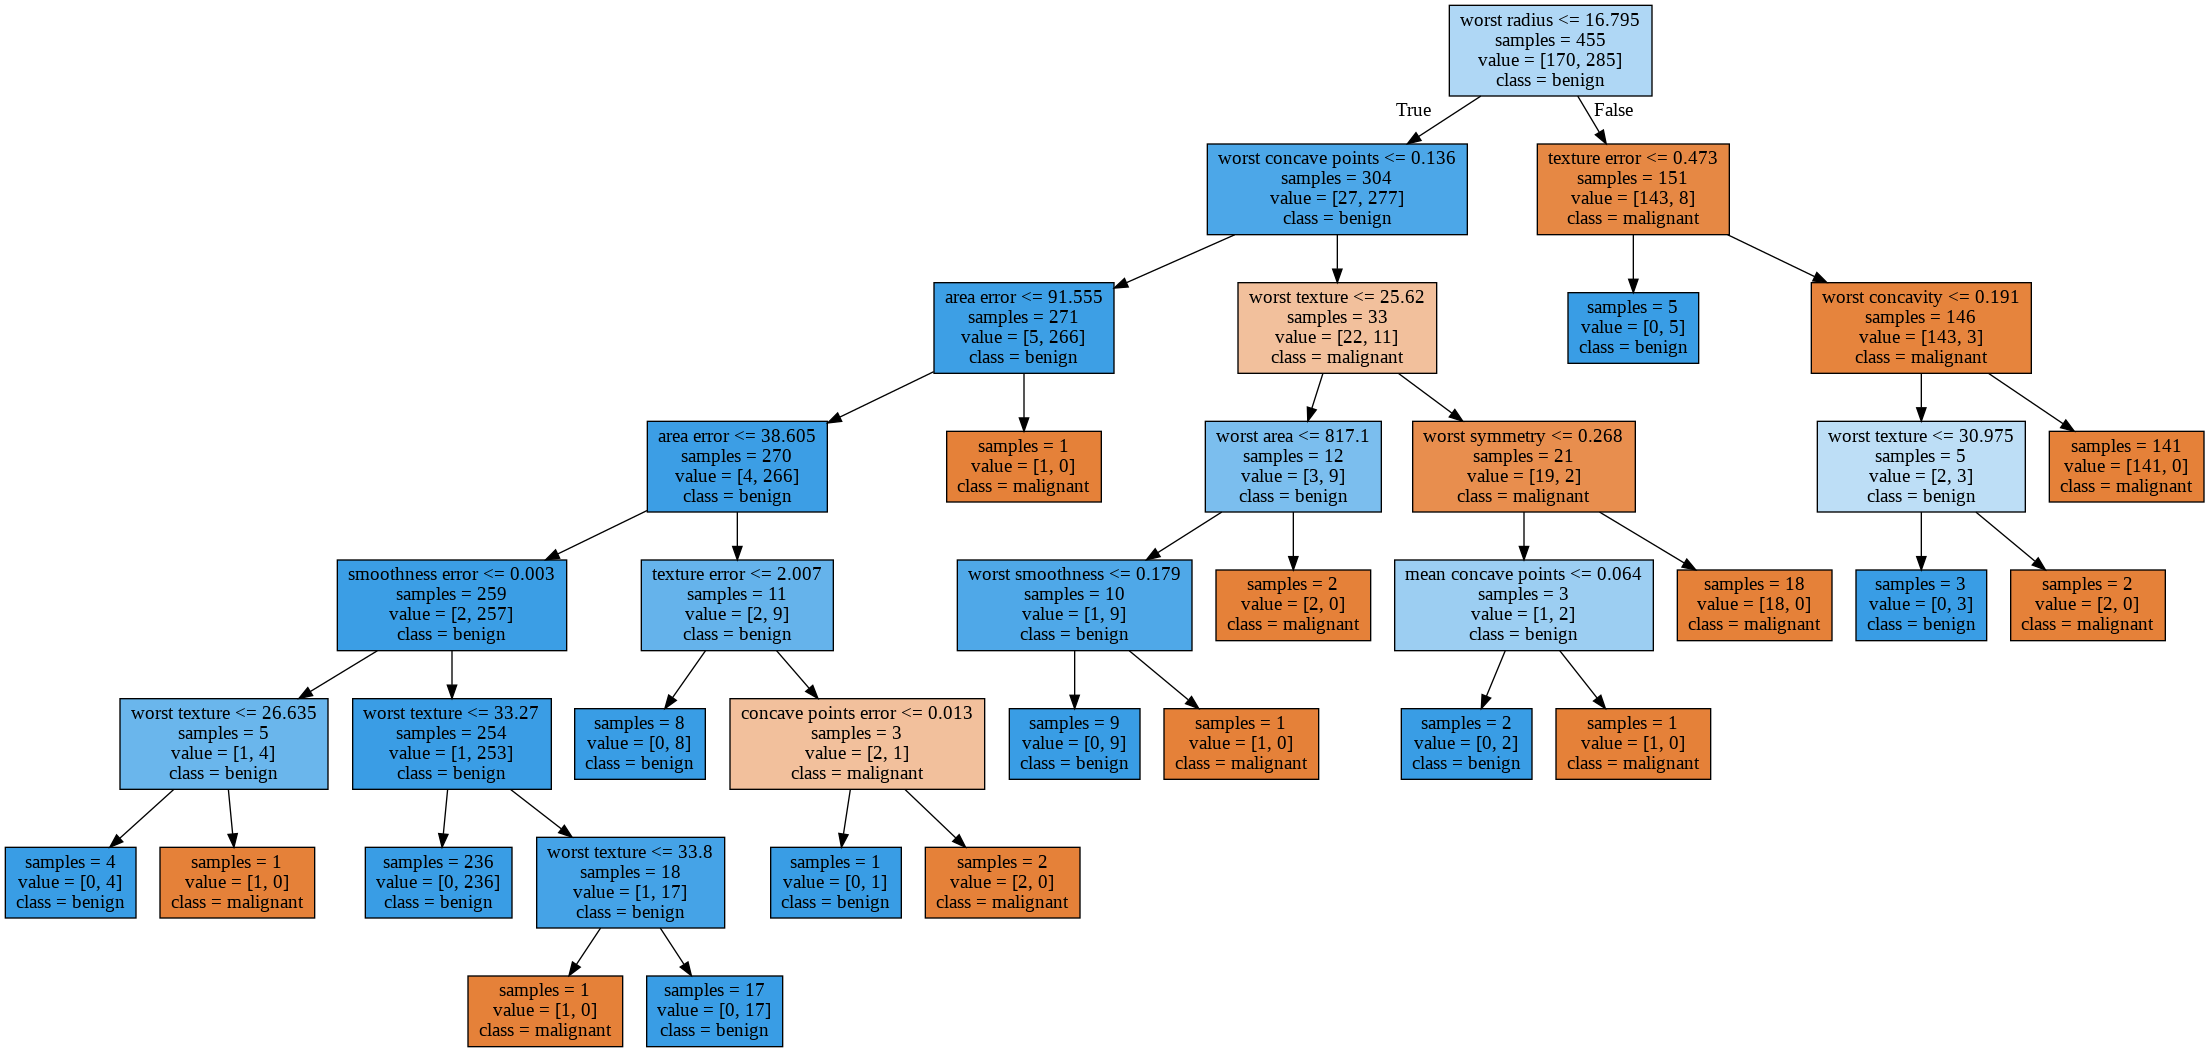

In [0]:
# Hiển thị file ảnh
from IPython.display import Image
Image(filename='tree_classifier.png')

** Mức độ quan trọng của các thuộc tính **

In [0]:
tree.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00626075, 0.        , 0.        ,
       0.        , 0.05266073, 0.        , 0.01208478, 0.00177016,
       0.        , 0.        , 0.00626075, 0.        , 0.        ,
       0.69781114, 0.05888116, 0.        , 0.01267802, 0.00845201,
       0.        , 0.01632512, 0.11608267, 0.01073271, 0.        ])

In [0]:
# Import matplotlib
import matplotlib.pyplot as plt

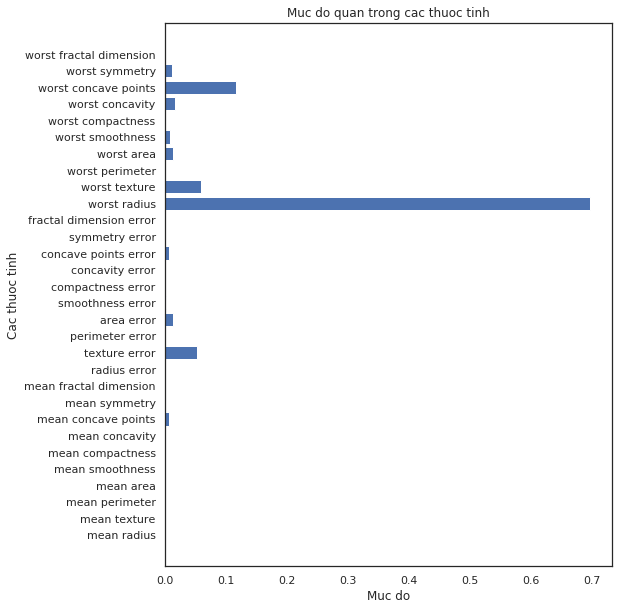

In [0]:
features = cancer.feature_names
n = len(features)
plt.figure(figsize = (8,10))
plt.barh(range(n), tree.feature_importances_)
plt.yticks(range(n), features)
plt.title('Muc do quan trong cac thuoc tinh')
plt.ylabel('Cac thuoc tinh')
plt.xlabel('Muc do')
plt.show()

## 2.2 Tập dữ liệu auto

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [0]:
data = pd.read_csv("data/auto-mpg.csv")

In [0]:
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [0]:
x = data['displacement']
y = data['mpg']

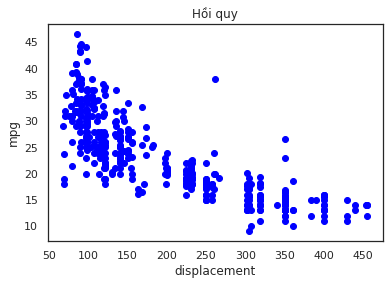

In [0]:
plt.scatter(x, y, c='blue')
plt.xlabel("displacement")
plt.ylabel("mpg")
plt.title("Hồi quy")
plt.show()

In [0]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [0]:
x = x.values.reshape(-1,1)
y = y.values.reshape(-1,1)

In [0]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=3)

In [0]:
dt = DecisionTreeRegressor(max_depth=3, min_samples_leaf=1, random_state=3)

In [0]:
dt.fit(x_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=3, splitter='best')

In [0]:
y_pred = dt.predict(x_test)

In [0]:
mse_dt = MSE(y_test, y_pred)

In [0]:
print(np.sqrt(mse_dt))

4.710198071342834


In [0]:
xx = np.linspace(min(x), max(x), 400).reshape(-1,1)

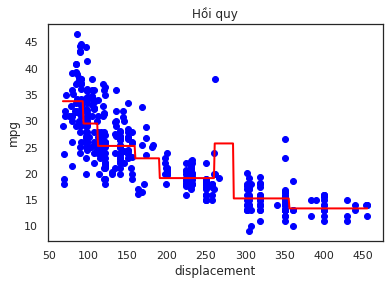

In [0]:
plt.scatter(x, y, c='blue')
plt.plot(xx, dt.predict(xx), color="red", linewidth=2)
plt.xlabel("displacement")
plt.ylabel("mpg")
plt.title("Hồi quy")
plt.show()

In [0]:
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file='tree.dot', feature_names=['displacement'])

In [0]:
! dot -Tpng tree.dot > tree.png

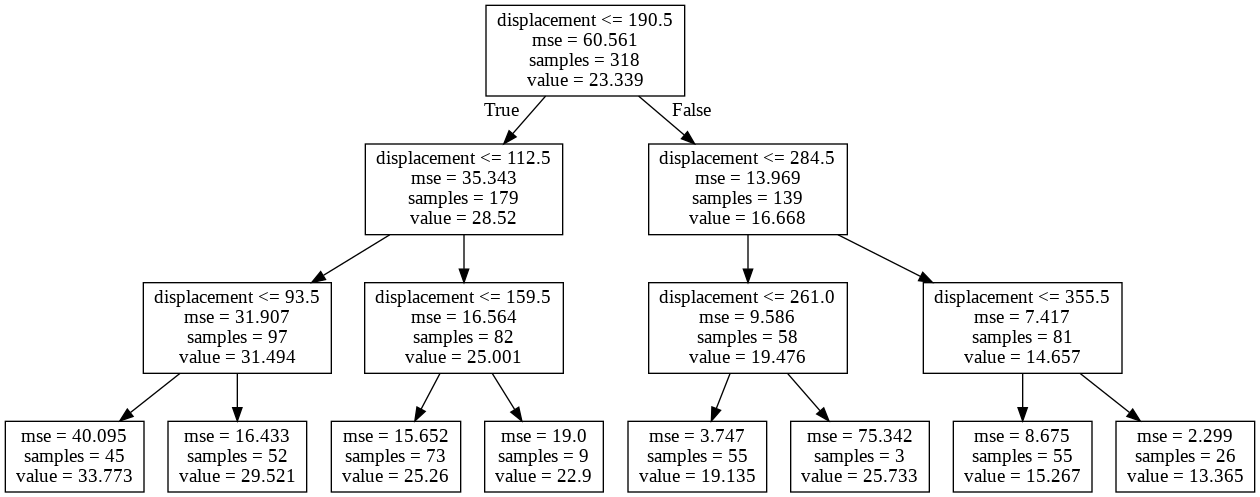

In [0]:
from IPython.display import Image
Image(filename='tree.png')

## Hồi quy cây ra quyết định

In [0]:
data = pd.read_csv("data/autompg.csv")
features = data.columns.values[1:][:-1]

In [0]:
features

array(['cylinders', 'displacement', 'horsepower', 'weight',
       'acceleration', 'model year', 'origin'], dtype=object)

In [0]:
x = data[features].values

In [0]:
y = data['mpg']

In [0]:
regressor = DecisionTreeRegressor(max_depth=3)

In [0]:
regressor.fit(x, y)

DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
from sklearn.tree import export_graphviz 
export_graphviz(regressor, out_file='tree_multi.dot', feature_names=features)
! dot -Tpng tree_multi.dot > tree_multi.png

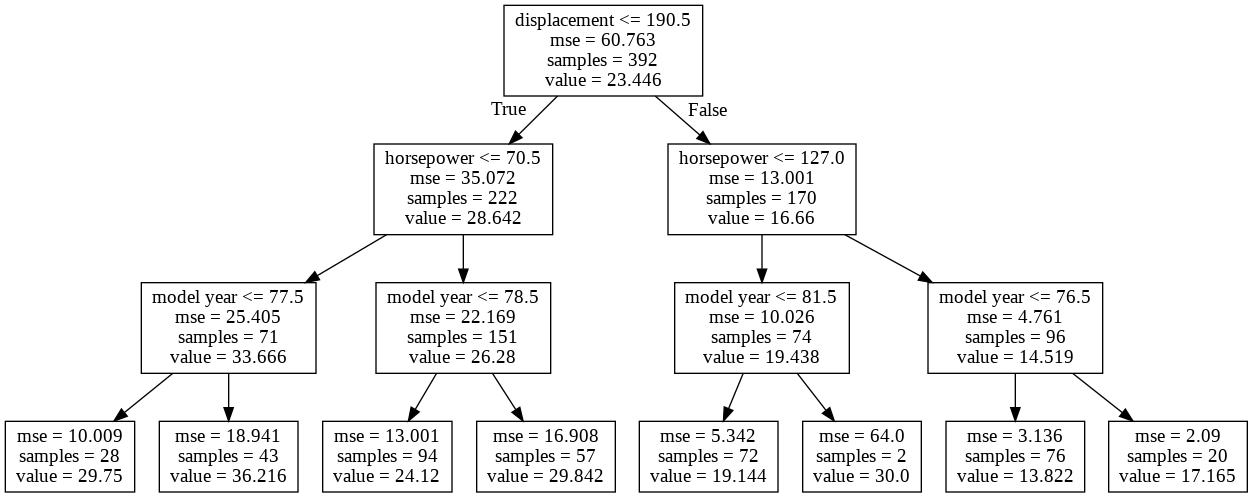

In [0]:
from IPython.display import Image
Image(filename = 'tree_multi.png')

In [0]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y, regressor.predict(x))

2.4683364168562116

In [0]:
MSE(y, regressor.predict(x))

10.391210202107787

In [0]:
#Tìm cách set up LLRE

In [0]:
import plotly.express as px

#px.set_mapbox_access_token(open(".mapbox_token").read())

px.set_mapbox_access_token("pk.eyJ1IjoiY2hyaWRkeXAiLCJhIjoiY2ozcGI1MTZ3MDBpcTJ3cXR4b3owdDQwaCJ9.8jpMunbKjdq1anXwU5gxIw")

carshare = px.data.carshare()

fig = px.scatter_mapbox(carshare, lat="centroid_lat", lon="centroid_lon",     color="peak_hour", size="car_hours",

                  color_continuous_scale=px.colors.cyclical.IceFire, size_max=15, zoom=10)

fig.show()

In [0]:
fig.add_choropleth()

In [0]:
import plotly.express as px
gapminder = px.data.gapminder().query("year == 2007")
fig = px.scatter_geo(gapminder, locations="iso_alpha",
                     size="pop", # size of markers, "pop" is one of the columns of gapminder
                     )
fig.show()

In [0]:
import plotly
plotly.offline.plot(fig, filename = "map.html")

'map.html'

In [0]:
import folium
from folium.plugins import MarkerCluster
import pandas as pd

In [0]:
boulder_coords = [22.696188, 104.946272]

my_map = folium.Map(location=boulder_coords, zoom_start=13)
my_map

In [0]:
# my_map.add_child(folium.Marker(location=[lat, lon], popup = name, icon= folium.Icon(color= color(elev))))
my_map.save(outfile="Ha_giang")